In this tutorial, we will simulate a naive model of a micrograph. In particular, we will simulate a batch of images of the same particle at random poses, then sum over them.

The goal of this tutorial is to learn how to vmap in `cryojax`'s recommended pattern. Namely, we will demonstrate this pattern using utilities in `cryojax.core`. These utilities are lightweight wrappers around `equinox`.

In [1]:
# Jax imports
import jax
import jax.numpy as jnp
import numpy as np

In [2]:
# Plotting imports and functions
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_image(image, fig, ax, cmap="gray", label=None, **kwargs):
    im = ax.imshow(image, cmap=cmap, origin="lower", **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    if label is not None:
        ax.set(title=label)
    return fig, ax

In [3]:
# CryoJAX imports
import cryojax.simulator as cs
from cryojax.rotations import SO3
from cryojax.io import read_array_with_spacing_from_mrc

First, we will build the image formation modeling components that we do not want to vmap over.

In [5]:
# First, load the scattering potential and projection method
filename = "./data/ribosome_4ug0_scattering_potential_from_cistem.mrc"
real_voxel_grid, voxel_size = read_array_with_spacing_from_mrc(filename)
potential = cs.FourierVoxelGridPotential.from_real_voxel_grid(
    real_voxel_grid, voxel_size, pad_scale=1.5
)
integrator = cs.FourierSliceExtract(interpolation_order=1)

# ... and build the instrument
optics = cs.WeakPhaseOptics(
    ctf=cs.CTF(defocus_u_in_angstroms=10000.0, defocus_v_in_angstroms=10000.0, voltage_in_kilovolts=300.0)
)
instrument = cs.Instrument(optics)

# ... and finally the config
shape = (400, 600)
pixel_size = potential.voxel_size  # Angstroms
image_size = np.asarray(shape) * pixel_size
config = cs.ImageConfig(shape, pixel_size, pad_scale=1.5)

Now we will construct an `ImagePipeline` by batching over a set of random number generator keys.

In [6]:
from jaxtyping import PRNGKeyArray
from functools import partial


@partial(jax.vmap, in_axes=[0, None])
def make_poses(
    key: PRNGKeyArray,
    config: cs.ImageConfig,
):
    # ... instantiate rotations
    rotation = SO3.sample_uniform(key)
    # ... now in-plane translation
    ny, nx = config.shape
    in_plane_offset_in_angstroms = (
        jax.random.uniform(key, (2,), minval=-0.5, maxval=0.5)
        * jnp.asarray((nx, ny))
        * config.pixel_size
    )
    # ... convert 2D in-plane translation to 3D, setting the out-of-plane translation to zero
    offset_in_angstroms = jnp.pad(in_plane_offset_in_angstroms, ((0, 1),))
    # Build the pose and return
    return cs.QuaternionPose.from_rotation_and_translation(
        rotation, offset_in_angstroms
    )

In [7]:
# Generate RNG keys
number_of_poses = 100
keys = jax.random.split(jax.random.PRNGKey(1234), number_of_poses)

# ... instantiate the poses
poses = make_poses(keys, config)

# ... build the Specimen and ImagePipeline as usual
specimen = cs.Specimen(potential, integrator, poses)
pipeline = cs.ImagePipeline(config, specimen, instrument)

This may be a little odd at first. We have contructed a pipeline, where if we were to directly call its `render` method, it would not work. Think of it this way: because we created our `pose`s with a `vmap`, functions can now only be called after crossing `vmap` boundaries. There is very good reason for this! To learn more, read the section of the equinox documentation on [model ensembling](https://docs.kidger.site/equinox/tricks/#ensembling).

Now that we have an `ImagePipeline` with a batched set of poses, we need some way of telling our `vmap` exactly what pytree leaves are batched. One way `equinox` does this is by using pointers to particular pytree leaves to create what is called a `filter_spec`.

In [8]:
import cryojax.core as cjc

# ... specify which leaves we would like to vmap over
where = lambda pipeline: pipeline.specimen.pose
# ... use a cryojax wrapper to return a filter_spec
filter_spec = cjc.get_filter_spec(pipeline, where)

Here, `filter_spec` is a pytree of booleans of the same structure as `pipeline`. The values are `True` at leaves that we do want to `vmap` over and `False` where we don't. Filtered transformations are a cornerstone to `equinox` and it is highly recommended to learn about them. See [here](https://docs.kidger.site/equinox/examples/frozen_layer/) in the equinox documentation for reading.

Above we have used a `cryojax` utility routine for creating a `filter_spec`, called `cryojax.core.get_filter_spec`. Next, we will finally define functions to batch and sum over images! To do this, we will again use a `cryojax` wrapper to `equinox` called `filter_vmap_with_spec`. This batches over a pytree, only at leaves specified by `filter_spec`. 

In [9]:
import equinox as eqx


@partial(cjc.filter_vmap_with_spec, filter_spec=filter_spec)
def compute_image_stack(pipeline):
    """Compute a batch of images at different poses,
    specified by the `filter_spec`.
    """
    return pipeline.render()


@eqx.filter_jit
def compute_micrograph(pipeline):
    """Sum together the image stack."""
    return jnp.mean(compute_image_stack(pipeline), axis=0)

(<Figure size 550x550 with 2 Axes>,
 <Axes: title={'center': 'Sum of random poses'}>)

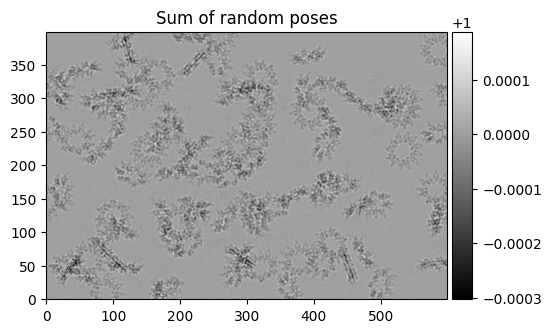

In [10]:
# Compute the image and plot
fig, ax = plt.subplots(figsize=(5.5, 5.5))
micrograph = compute_micrograph(pipeline)
plot_image(micrograph, fig, ax, label="Sum of random poses", interpolation=None)

**What next?**

It is highly recommended to learn about about [pytree manipulation](https://docs.kidger.site/equinox/api/manipulation/) in equinox. In particular, read about [eqx.partition and eqx.combine](https://docs.kidger.site/equinox/api/manipulation/#equinox.partition). `cryojax` has made the choice to hide away some of these details with it's utility routines, but this is meant to just ease users into just using `equinox` for themselves.

This thread on the `equinox` github may also be useful: [https://github.com/patrick-kidger/equinox/issues/618](https://github.com/patrick-kidger/equinox/issues/618).